# HELP International is an international humanitarian NGO that is committed to fighting poverty and providing
# the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. 
# It runs a lot of operational projects from time to time along with advocacy drives
# to raise awareness as well as for funding purposes.

 

# After the recent funding programmes, they have been able to raise around $ 10 million. 
# Now the CEO of the NGO needs to decide how to use this money strategically and effectively. 
# The significant issues that come while making this decision are mostly related to choosing 
# the countries that are in the direst need of aid. 

# My job is to categorise the countries using some socio-economic and health factors that determine
# the overall development of the country. 
# Then you need to suggest the countries which the CEO needs to focus on the most.



# 1. Reading ,understing as well perforing EDA in the data set.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage  # scipy scientific python
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### Reading the data set

In [3]:
Country_data=pd.read_csv('Country-data.csv')
Country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
Country_data.shape 

(167, 10)

In [5]:
Country_data.info() ## From this step we can chech the null values but there is no null values in the data set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
Country_data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [7]:
Country_data.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

## Doing univariate and bi variate analysis

In [8]:
## This step will tell us as per the gdpp how the export is changing.
gdpp_max=Country_data.groupby('gdpp')['exports'].max()
gdpp_max.head()

gdpp
231     8.92
327    19.10
334    41.10
348    22.20
399    16.80
Name: exports, dtype: float64

## These pair plot will tell us how each columns are varying with each other


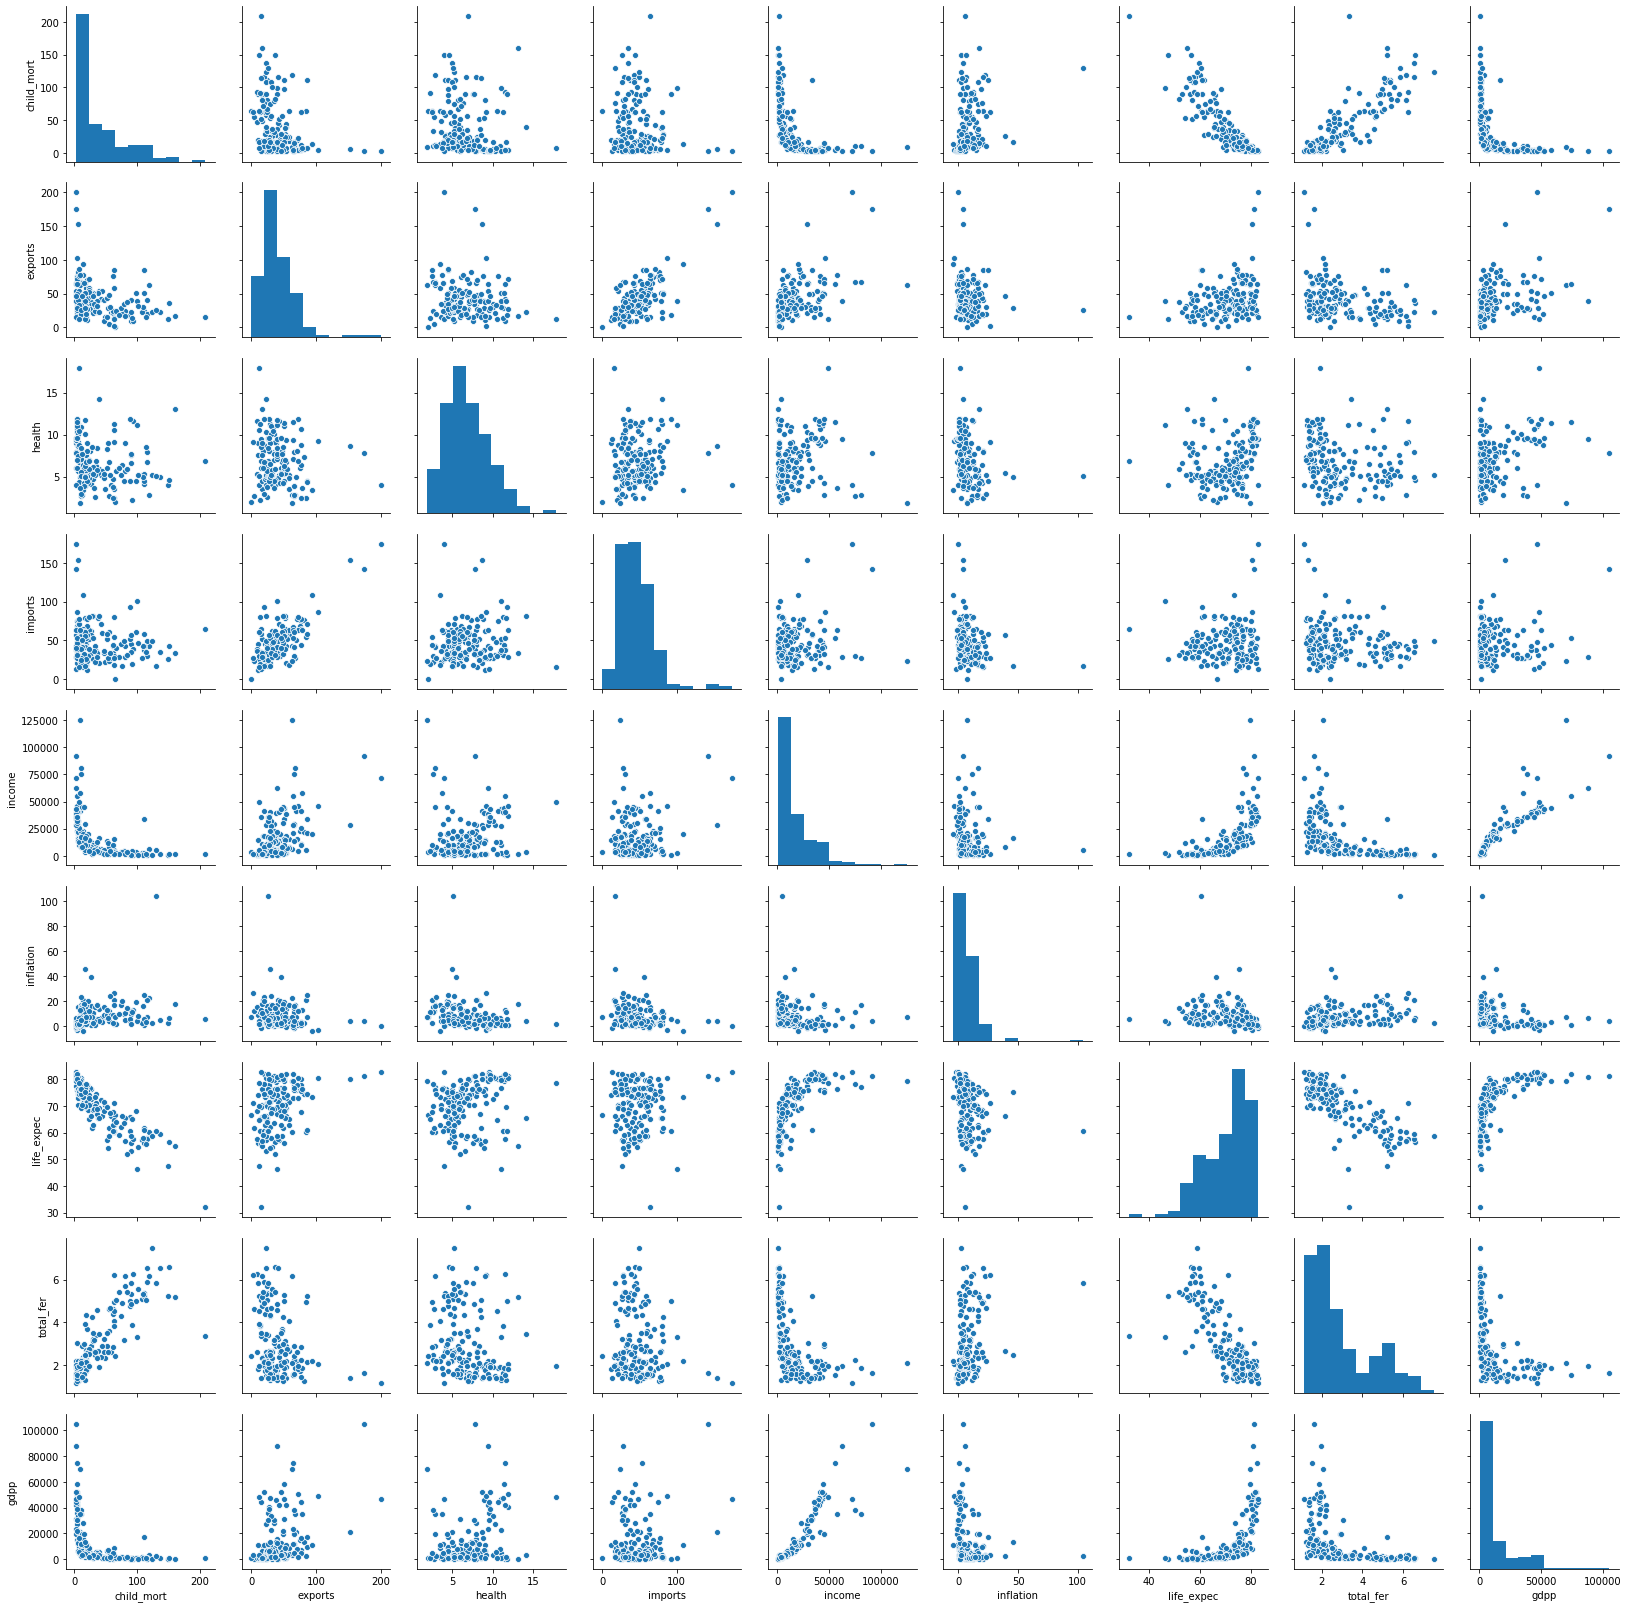

In [9]:
sns.pairplot(Country_data)
plt.show()

## Outlier checking: This outiler checking willl have to be done for on the below mention columns


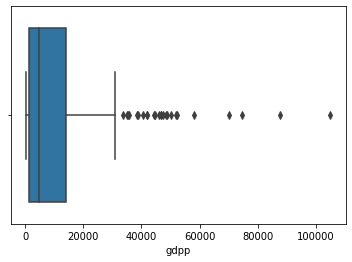

In [10]:

sns.boxplot(Country_data['gdpp'])
plt.show()

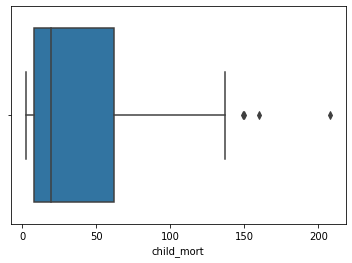

In [70]:
sns.boxplot(Country_data['child_mort'])
plt.show()


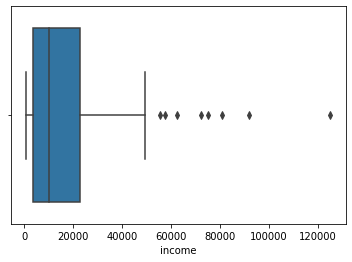

In [12]:
sns.boxplot(Country_data['income'])
plt.show()

## In the below step we can see that no. of outiler are more but if we will remove that it well the effect of over all data
## as the data consist no. of count

In [13]:
Q1 = Country_data['income'].quantile(0.01)
Q4 = Country_data['income'].quantile(0.99)
Country_data['income'][Country_data['income'] <= Q1]=Q1
Country_data['income'][Country_data['income'] >= Q4]=Q4
Country_data.shape

(167, 10)

# 2. Prepare data for modelling



In [14]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [15]:
# No we have to check the hopkins measure which tells us is the data is for clustering or not.
# since the value high the data is good for clustering

Country_data_drop=Country_data.drop('country',axis=1)
hopkins(Country_data_drop)

0.8915905441200703

In [16]:
## this data will be used for clustering
Country_data_drop.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200


## Scalling the data

In [17]:
standard_scaler = StandardScaler()
Country_data_drop= standard_scaler.fit_transform(Country_data_drop)
Country_data_drop=pd.DataFrame(Country_data_drop)
Country_data_drop.columns=['child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp']

Country_data_drop.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.851772,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.387025,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.221124,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.612136,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.125202,-0.601749,0.704258,-0.541946,-0.041817


# 3. Modelling

## K Mean clustering

In [18]:
## Finding the optimal no. of cluster Methord 1. Elbow curve/SSd(Sum od Square distances)
ssd=[]
range_n_clusters=[2,3,4,6,7,8]
for num_clusters in range_n_clusters:
    kmeans=KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(Country_data_drop)
    ssd.append(kmeans.inertia_)
ssd

[1044.944069329671,
 823.4947030548659,
 718.857343505769,
 553.9161024765112,
 500.4584788905965,
 447.4887651973108]

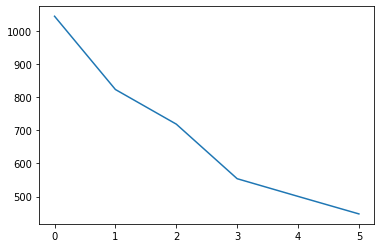

In [19]:
# In the X axis 0,1,2,3,4,5 are the index of the clusters i.e 2,3,4,6,7,8
# the gradiant change between the cluster 2 and 3 is as good as between 3 and 4
plt.plot(ssd)

In [20]:
## Finding the optimal no. of cluster Methord 2.Silhouette analysis
range_n_clusters=[2,3,4,6,7,8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans=KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(Country_data_drop)
    
    cluster_labels=kmeans.labels_
    # silhouette score
    silhouette_avg=silhouette_score(Country_data_drop,cluster_labels)
    print('For n_clusters={0},the silhouette score is {1}'.format(num_clusters,silhouette_avg))
    
    

For n_clusters=2,the silhouette score is 0.2886021621636194
For n_clusters=3,the silhouette score is 0.28669291273137615
For n_clusters=4,the silhouette score is 0.29926818610322936
For n_clusters=6,the silhouette score is 0.22233442051238922
For n_clusters=7,the silhouette score is 0.20435351375376176
For n_clusters=8,the silhouette score is 0.2208998209447998


## from the above silhouette score number  cluster choosen must be  n=4 as the score is nearer to 1 it tells but if we can see the Silhouette score between cluster 3 and 4 is not very large there fore we will select n=3
## data points are very similar to the data points with in the cluster



In [21]:
# final model with k =3
kmeans=KMeans(n_clusters=3,max_iter=50)
kmeans.fit(Country_data_drop)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [22]:
kmeans.labels_

array([2, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2,
       1, 0, 1, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 0, 0,
       0, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 2, 0, 1, 1, 2, 2, 1,
       2, 1, 0, 1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2,
       2, 1, 1, 0, 1, 2, 2, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       0, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1, 1,
       2, 0, 0, 0, 1, 2, 0, 0, 1, 1, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2])

In [23]:
## this step is to copy the old data
Country_data_org = Country_data.copy()

In [24]:
Country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200


In [25]:
col=Country_data.columns
col

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [26]:
## In this step we will merging the country name to the data having cluster_id
Country_data_km=pd.concat([Country_data.reset_index().drop('index',axis=1),pd.Series(kmeans.labels_)],axis=1)
Country_data_km.columns=['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp','cluster_id']
Country_data_km.head()                        

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553,2
1,Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200,1


In [27]:
Country_data_km.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
cluster_id    0
dtype: int64

In [28]:
Country_data_km['cluster_id'].value_counts()

1    84
2    47
0    36
Name: cluster_id, dtype: int64

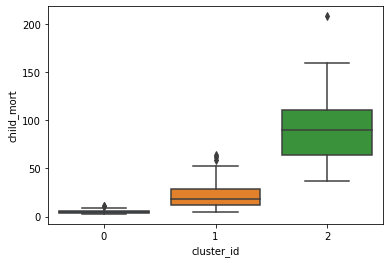

In [29]:
## ploting as per the cluster_id for the below box plot we can see that cluster wise how these 3 cloumns are behaving
## in different cluster
sns.boxplot(x='cluster_id',y='child_mort',data=Country_data_km)
plt.show()

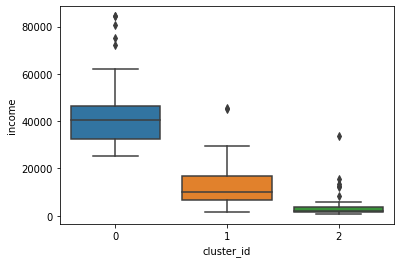

In [30]:
sns.boxplot(x='cluster_id',y='income',data=Country_data_km)
plt.show()

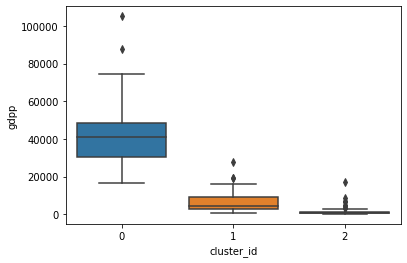

In [31]:
sns.boxplot(x='cluster_id',y='gdpp',data=Country_data_km)
plt.show()

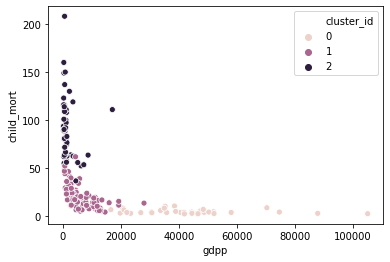

In [32]:
## now looking from diffrent plot in which from the help of scatter plot we can see how 2 columns are varing in in different 
## clusters
sns.scatterplot(x='gdpp',y='child_mort',hue='cluster_id',legend = 'full',data=Country_data_km)

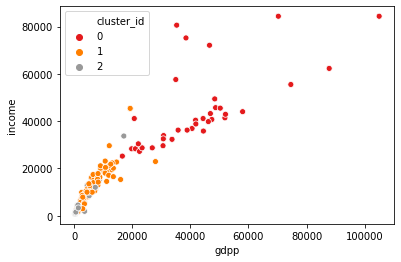

In [33]:
sns.scatterplot(x='gdpp',y='income',hue='cluster_id',legend = 'full',data=Country_data_km, palette='Set1')

# 4.Final analysis and recommendation 

In [34]:
#Let's use the concept of binning for cluster 1
Country_data_km[Country_data_km['cluster_id']==0]['country']

7                 Australia
8                   Austria
11                  Bahrain
15                  Belgium
23                   Brunei
29                   Canada
42                   Cyprus
43           Czech Republic
44                  Denmark
53                  Finland
54                   France
58                  Germany
60                   Greece
68                  Iceland
73                  Ireland
74                   Israel
75                    Italy
77                    Japan
82                   Kuwait
91               Luxembourg
98                    Malta
110             Netherlands
111             New Zealand
114                  Norway
122                Portugal
123                   Qatar
133               Singapore
134         Slovak Republic
135                Slovenia
138             South Korea
139                   Spain
144                  Sweden
145             Switzerland
157    United Arab Emirates
158          United Kingdom
159           United

In [35]:
# this step we will us the country name in Cluster 1 and in sorted form
Country_data_km[Country_data_km['cluster_id']==0].sort_values(by=['child_mort','income','gdpp'],ascending=[False,False,False])

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
82,Kuwait,10.8,66.7,2.63,30.4,75200.0,11.200,78.2,2.21,38500,0
23,Brunei,10.5,67.4,2.84,28.0,80600.0,16.700,77.1,1.84,35300,0
123,Qatar,9.0,62.3,1.81,23.8,84374.0,6.980,79.5,2.07,70300,0
157,United Arab Emirates,8.6,77.7,3.66,63.6,57600.0,12.500,76.5,1.87,35000,0
11,Bahrain,8.6,69.5,4.97,50.9,41100.0,7.440,76.0,2.16,20700,0
159,United States,7.3,12.4,17.90,15.8,49400.0,1.220,78.7,1.93,48400,0
134,Slovak Republic,7.0,76.3,8.79,77.8,25200.0,0.485,75.5,1.43,16600,0
98,Malta,6.8,153.0,8.65,154.0,28300.0,3.830,80.3,1.36,21100,0
111,New Zealand,6.2,30.3,10.10,28.0,32300.0,3.730,80.9,2.17,33700,0
29,Canada,5.6,29.1,11.30,31.0,40700.0,2.870,81.3,1.63,47400,0


In [36]:
## binning for cluster 2
Country_data_km[Country_data_km['cluster_id']==1]['country']

1                  Albania
2                  Algeria
4      Antigua and Barbuda
5                Argentina
6                  Armenia
              ...         
160                Uruguay
161             Uzbekistan
162                Vanuatu
163              Venezuela
164                Vietnam
Name: country, Length: 84, dtype: object

In [37]:
## this step we will us the country name in Cluster 2 and in sorted form
Country_data_km[Country_data_km['cluster_id']==1].sort_values(by=['child_mort','income','gdpp'],ascending=[False,False,False])

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
107,Myanmar,64.4,0.109,1.97,0.0659,3720.0,7.040,66.8,2.41,988,1
154,Turkmenistan,62.0,76.300,2.50,44.5000,9940.0,2.310,67.9,2.83,4440,1
69,India,58.8,22.600,4.05,27.1000,4410.0,8.980,66.2,2.60,1350,1
146,Tajikistan,52.4,14.900,5.98,58.6000,2110.0,12.500,69.6,3.51,738,1
12,Bangladesh,49.4,16.000,3.52,21.8000,2440.0,7.140,70.4,2.33,758,1
...,...,...,...,...,...,...,...,...,...,...,...
67,Hungary,6.0,81.800,7.33,76.5000,22300.0,2.330,74.5,1.25,13100,1
121,Poland,6.0,40.100,7.46,42.1000,21800.0,1.660,76.3,1.41,12600,1
41,Croatia,5.5,37.600,7.76,38.1000,20100.0,0.821,76.3,1.55,13500,1
14,Belarus,5.5,51.400,5.61,64.5000,16200.0,15.100,70.4,1.49,6030,1


In [38]:
## binning for cluster 3
Country_data_km[Country_data_km['cluster_id']==2]['country']

0                   Afghanistan
3                        Angola
17                        Benin
21                     Botswana
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
49            Equatorial Guinea
50                      Eritrea
55                        Gabon
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
72                         Iraq
80                        Kenya
81                     Kiribati
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
99                   Mauritania
106     

In [39]:
# this step we will us the country name in Cluster 3 and in sorted form

Country_data_km[Country_data_km['cluster_id']==2].sort_values(by=['child_mort','income','gdpp'],ascending=[False,False,False])

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
66,Haiti,208.0,15.30,6.91,64.7,1500.00,5.450,32.1,3.33,662,2
132,Sierra Leone,160.0,16.80,13.10,34.5,1220.00,17.200,55.0,5.20,399,2
32,Chad,150.0,36.80,4.53,43.5,1930.00,6.390,56.5,6.59,897,2
31,Central African Republic,149.0,11.80,3.98,26.5,888.00,2.010,47.5,5.21,446,2
97,Mali,137.0,22.80,4.98,35.1,1870.00,4.370,59.5,6.55,708,2
113,Nigeria,130.0,25.30,5.07,17.4,5150.00,104.000,60.5,5.84,2330,2
112,Niger,123.0,22.20,5.16,49.1,814.00,2.550,58.8,7.49,348,2
3,Angola,119.0,62.30,2.85,42.9,5900.00,22.400,60.1,6.16,3530,2
25,Burkina Faso,116.0,19.20,6.74,29.6,1430.00,6.810,57.9,5.87,575,2
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,742.24,20.800,57.5,6.54,334,2


# Final recommendation  

## From the above analysis it is obsevered that coutries in cluster 1 and 3 are very much requied of the aid.
### The top 5 countries which need the aid are as follow
### 1.Haiti
### 2.Sierra Leone
### 3.Chad
### 4.Myanmmar
### 5.Turkmenistan


## We will be performing other cluster algorithm with the same data set

## Hierarchical Clustering



In [41]:
Country_data_km.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553,2
1,Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200,1


In [42]:
Country_data_km_hc=Country_data_km.drop('country',axis=1)
Country_data_km_hc.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553,2
1,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090,1
2,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460,1
3,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530,2
4,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200,1


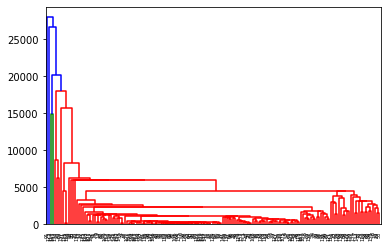

In [43]:
   # single linkage 
mergings=linkage(Country_data_km_hc,method='single',metric='euclidean')
dendrogram(mergings)
plt.show()

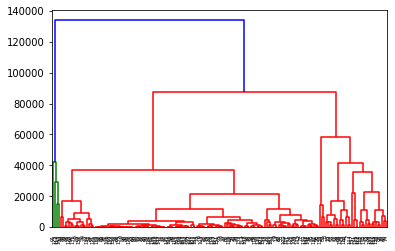

In [44]:
# complete linkage
mergings=linkage(Country_data_km_hc,method='complete',metric='euclidean')
dendrogram(mergings)
plt.show()

In [53]:
# 3 cluster
cut_tree(mergings,n_clusters=3).shape

(167, 1)

In [54]:
cluster_labels=cut_tree(mergings,n_clusters=3).reshape(-1,)
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [56]:

## assign cluster labels
Country_data['cluster_labels']=cluster_labels
Country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090,0
2,Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460,0
3,Angola,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200,0


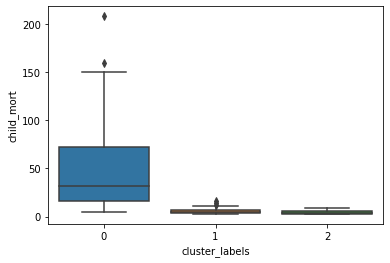

In [67]:
## Now from the box plot we will see that how variables are behaving in each of the cluster 

## We will go with varibale 'child_mort ,'income' and 'gdpp'

sns.boxplot(x='cluster_labels',y='child_mort',data=Country_data)


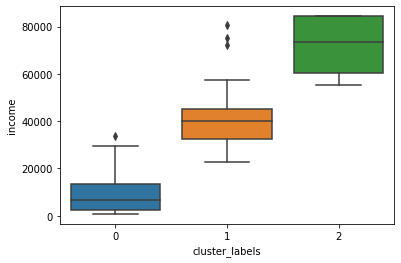

In [68]:
sns.boxplot(x='cluster_labels',y='income',data=Country_data)

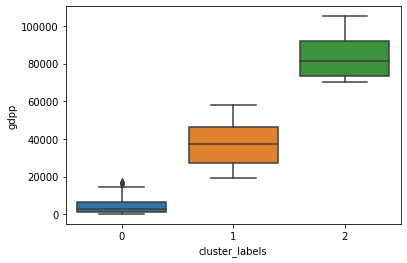

In [69]:
sns.boxplot(x='cluster_labels',y='gdpp',data=Country_data)

In [58]:
## binning for cluster 1
Country_data_km[Country_data['cluster_labels']==0]['country']

0              Afghanistan
1                  Albania
2                  Algeria
3                   Angola
4      Antigua and Barbuda
              ...         
162                Vanuatu
163              Venezuela
164                Vietnam
165                  Yemen
166                 Zambia
Name: country, Length: 129, dtype: object

In [60]:
# this step we will us the country name in Cluster 1 and in sorted form
Country_data[Country_data['cluster_labels']==0].sort_values(by=['child_mort','income','gdpp'],ascending=[False,False,False])

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
66,Haiti,208.0,15.3,6.91,64.7,1500.0,5.450,32.1,3.33,662,0
132,Sierra Leone,160.0,16.8,13.10,34.5,1220.0,17.200,55.0,5.20,399,0
32,Chad,150.0,36.8,4.53,43.5,1930.0,6.390,56.5,6.59,897,0
31,Central African Republic,149.0,11.8,3.98,26.5,888.0,2.010,47.5,5.21,446,0
97,Mali,137.0,22.8,4.98,35.1,1870.0,4.370,59.5,6.55,708,0
...,...,...,...,...,...,...,...,...,...,...,...
67,Hungary,6.0,81.8,7.33,76.5,22300.0,2.330,74.5,1.25,13100,0
121,Poland,6.0,40.1,7.46,42.1,21800.0,1.660,76.3,1.41,12600,0
41,Croatia,5.5,37.6,7.76,38.1,20100.0,0.821,76.3,1.55,13500,0
14,Belarus,5.5,51.4,5.61,64.5,16200.0,15.100,70.4,1.49,6030,0


In [61]:
## Binning for cluster 2
Country_data_km[Country_data['cluster_labels']==1]['country']

7                 Australia
8                   Austria
10                  Bahamas
11                  Bahrain
15                  Belgium
23                   Brunei
29                   Canada
42                   Cyprus
43           Czech Republic
44                  Denmark
53                  Finland
54                   France
58                  Germany
60                   Greece
68                  Iceland
73                  Ireland
74                   Israel
75                    Italy
77                    Japan
82                   Kuwait
98                    Malta
110             Netherlands
111             New Zealand
115                    Oman
122                Portugal
128            Saudi Arabia
133               Singapore
135                Slovenia
138             South Korea
139                   Spain
144                  Sweden
157    United Arab Emirates
158          United Kingdom
159           United States
Name: country, dtype: object

In [62]:
# this step we will us the country name in Cluster 2 and in sorted form
Country_data[Country_data['cluster_labels']==1].sort_values(by=['child_mort','income','gdpp'],ascending=[False,False,False])

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
128,Saudi Arabia,15.7,49.6,4.29,33.0,45400.0,17.200,75.1,2.96,19300,1
10,Bahamas,13.8,35.0,7.89,43.7,22900.0,-0.393,73.8,1.86,28000,1
115,Oman,11.7,65.7,2.77,41.2,45300.0,15.600,76.1,2.90,19300,1
82,Kuwait,10.8,66.7,2.63,30.4,75200.0,11.200,78.2,2.21,38500,1
23,Brunei,10.5,67.4,2.84,28.0,80600.0,16.700,77.1,1.84,35300,1
157,United Arab Emirates,8.6,77.7,3.66,63.6,57600.0,12.500,76.5,1.87,35000,1
11,Bahrain,8.6,69.5,4.97,50.9,41100.0,7.440,76.0,2.16,20700,1
159,United States,7.3,12.4,17.90,15.8,49400.0,1.220,78.7,1.93,48400,1
98,Malta,6.8,153.0,8.65,154.0,28300.0,3.830,80.3,1.36,21100,1
111,New Zealand,6.2,30.3,10.10,28.0,32300.0,3.730,80.9,2.17,33700,1


In [63]:
## Binning for cluster 3
Country_data_km[Country_data['cluster_labels']==2]['country']

91      Luxembourg
114         Norway
123          Qatar
145    Switzerland
Name: country, dtype: object

In [64]:
# this step we will us the country name in Cluster 3 and in sorted form
Country_data[Country_data['cluster_labels']==2].sort_values(by=['child_mort','income','gdpp'],ascending=[False,False,False])

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
123,Qatar,9.0,62.3,1.81,23.8,84374.0,6.980,79.5,2.07,70300,2
145,Switzerland,4.5,64.0,11.50,53.3,55500.0,0.317,82.2,1.52,74600,2
114,Norway,3.2,39.7,9.48,28.5,62300.0,5.950,81.0,1.95,87800,2
91,Luxembourg,2.8,175.0,7.77,142.0,84374.0,3.620,81.3,1.63,105000,2


# Final recommendation  

## From the above analysis it is obsevered that coutries in cluster 1 are very much requied of the aid.
## We have compare the data for CLuster 2 and 3 with cluster 1. Countries in those cluster are  having far better postion
## in terms of child_mort,income and gdpp

### The top 5 countries which need the aid are as follow
### 1.Haiti
### 2.Sierra Leone
### 3.Chad
### 4.Central African Republic
### 5.Mali